In [8]:
from langgraph.graph import StateGraph,START,END
from langchain_mistralai import ChatMistralAI
from dotenv import load_dotenv
from typing import Annotated,TypedDict,Literal
from pydantic import BaseModel ,Field
import operator
from langchain_core.messages import SystemMessage,HumanMessage

In [3]:
load_dotenv()

True

In [4]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [6]:
class TweetState(TypedDict):

    topic:str
    tweet:str
    evaluation:Literal["approved","need_improvement"]
    iteration:int
    max_iteration:int
    feedback:str

    tweet_history : Annotated[list[str],operator.add]
    feedback_history : Annotated[list[str],operator.add]

In [9]:
genrator_model = ChatMistralAI()
evaluator_model = ChatMistralAI()
optimizer_model = ChatMistralAI()
structured_evaluator_model = evaluator_model.with_structured_output(TweetEvaluation)

In [10]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = genrator_model.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [11]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_model.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [12]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_model.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [13]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [16]:
graph = StateGraph(TweetState)

# nodes

graph.add_node("generate_tweet",generate_tweet)
graph.add_node("evaluate_tweet",evaluate_tweet)
graph.add_node("optimize_tweet",optimize_tweet)

#edges
graph.add_edge(START,"generate_tweet")
graph.add_edge("generate_tweet","evaluate_tweet")
graph.add_conditional_edges("evaluate_tweet",route_evaluation,{"approved":END,"needs_improvement":"optimize_tweet"})

graph.add_edge("optimize_tweet","evaluate_tweet")

#compile

workflow = graph.compile()

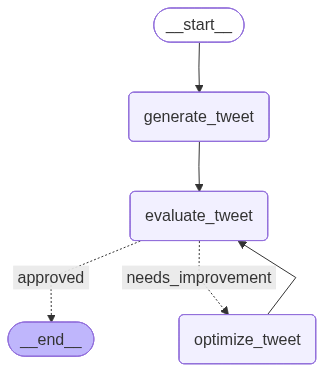

In [17]:
workflow

In [19]:
initial_state = {
    "topic": "railway",
    "iteration": 1,
    "max_iteration": 5
}
workflow.invoke(initial_state)

{'topic': 'railway',
 'tweet': '"When the train moves but my eyes don\'t: *smooth brain activates* 🚄🤯 #TrainStruggles #RailwayLife"\n\nThis version keeps the relatable concept but adds a more engaging and humorous twist with "smooth brain activates" and a stronger emoji combination. The hashtags are also more engaging and relevant.',
 'evaluation': 'approved',
 'iteration': 2,
 'max_iteration': 5,
 'feedback': 'The tweet "When the train moves but my eyes don\'t: *smooth brain activates* 🚄🤯 #TrainStruggles #RailwayLife" scores well on originality with its unique twist on a common experience. The humor is engaging and relatable, leveraging the popular "smooth brain" meme effectively. It\'s punchy and concise, making it scroll-stopping. The virality potential is high due to its relatability and the use of trending hashtags. The format is perfect, adhering to the character limit and avoiding any auto-reject triggers. Overall, it\'s a well-crafted tweet that balances humor and engagement ef